## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [3]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import os
from moviepy.editor import VideoFileClip

## Camera Calibration

This cell perfomes camera calibration using a certain number of calibration pictures of a chessboard, in order to obtain "mtx" - camera matrix - and "dist" - distortion coefficients - used to undistort raw pictures/video frame.

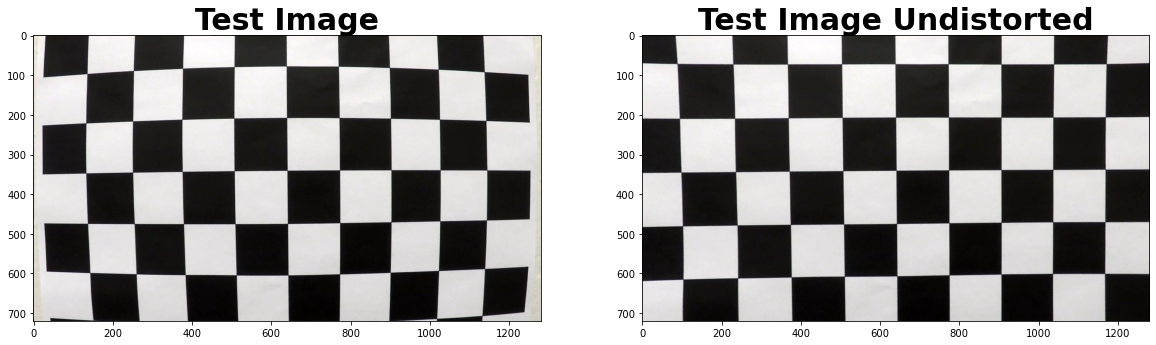

In [85]:
############### Camera calibration  ##################

# Path description for calibration images
path = os.getcwd()
cal_img_path = os.path.join(path,'camera_cal/')

# Cheesboard parameters
num_cornerx = 9
num_cornery = 6

# Object point array preparation
objp = np.zeros((num_cornery*num_cornerx,3), np.float32)
objp[:,:2] = np.mgrid[0:num_cornerx, 0:num_cornery].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# List of calibration images
images = glob.glob(cal_img_path + 'calibration*.jpg')

# Cache containing camera calibration parameter initialization
cache_cam_cal = {}

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = mpimg.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Grayscale conversion (RGB2GRAY because I am using matplotlib.image.imread)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (num_cornerx,num_cornery), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Camera calibration cache populated
cache_cam_cal["mtx"] = mtx
cache_cam_cal["dist"] = dist

# Undistortion function definition
def undistortion(img):
    
    dst = cv2.undistort(img, cache_cam_cal["mtx"], cache_cam_cal["dist"], None, cache_cam_cal["mtx"])
    
    return dst

# Sanity check for camera calibration
test_img = mpimg.imread(cal_img_path + 'calibration1.jpg')
test_dst = undistortion(test_img)

# Plot source (distorted) image and undistorted image as comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Test Image', fontweight="bold", size=30)
ax1.imshow(test_img)
ax2.set_title('Test Image Undistorted', fontweight="bold", size=30)
ax2.imshow(test_dst)
plt.savefig('ChessUndist')

## Function definition for the Pipeline - Thresholding and Combination

These functions apply different algorithms for lane recognition.
* Function "threshold()" is in charge of selecting the filter given by the user and relative thresholds, and call other functions - activate functions - (e.g. abs_sobel_threshold) in order to apply the filter
* Function "combine()" is used to combine the binary images resulting from each function activated. It returns the final binary output.

In [5]:
######### Thresholding & Combination #########

def abs_sobel_threshold(image, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate directional gradient
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    
    grad_binary = np.zeros_like(scaled_sobel)
    
    grad_binary[(scaled_sobel >= min_th) & (scaled_sobel <= max_th)] = 1
    
    return grad_binary

def mag_threshold(image, sobel_kernel = 3, thresh = (0, 255)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate gradient magnitude
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    
    # Apply threshold
    
    mag_binary = np.zeros_like(scaled_sobel)
    
    mag_binary[(scaled_sobel >= min_th) & (scaled_sobel <= max_th)] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel = 3, thresh = (0, np.pi/2)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate gradient direction
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    
    dir_binary = np.zeros_like(grad_dir)
    
    dir_binary[(grad_dir >= min_th) & (grad_dir <= max_th)] = 1
    
    return dir_binary

def hls_threshold(image, hls_channel = 's', thresh = (0, 255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    if hls_channel == 'h':
        channel = h_channel
        #print('Chosen h_channel')
    elif hls_channel == 'l':
        channel = l_channel
        #print('Chosen l_channel')
    elif hls_channel == 's':
        channel = s_channel
        #print('Chosen s_channel')
    
    hlsbinary = np.zeros_like(channel)
    hlsbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return hlsbinary

def hsv_threshold(image, hsv_channel = 's', thresh = (0, 255)):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    if hsv_channel == 'h':
        channel = h_channel
        #print('Chosen h_channel')
    elif hsv_channel == 's':
        channel = s_channel
        #print('Chosen l_channel')
    elif hsv_channel == 'v':
        channel = v_channel
        #print('Chosen s_channel')
    
    hsvbinary = np.zeros_like(channel)
    hsvbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return hsvbinary

def color_threshold(image, color_channel = 'r', thresh = (0, 255)):
    
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    if color_channel == 'r':
        channel = r_channel
        #print('Chosen h_channel')
    elif color_channel == 'g':
        channel = g_channel
        #print('Chosen l_channel')
    elif color_channel == 'b':
        channel = b_channel
        #print('Chosen s_channel')
        
    colorbinary = np.zeros_like(channel)
    colorbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return colorbinary

def yuv_threshold(image, yuv_channel = 'y', thresh = (0, 255)):
    
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    y_channel = image[:,:,0]
    u_channel = image[:,:,1]
    v_channel = image[:,:,2]
    
    if yuv_channel == 'y':
        channel = y_channel
        #print('Chosen h_channel')
    elif yuv_channel == 'u':
        channel = u_channel
        #print('Chosen l_channel')
    elif yuv_channel == 'v':
        channel = v_channel
        #print('Chosen s_channel')
        
    yuvbinary = np.zeros_like(channel)
    yuvbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return yuvbinary

def lab_threshold(image, lab_channel = 'l', thresh = (0, 255)):
    
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    l_channel = image[:,:,0]
    a_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    if lab_channel == 'l':
        channel = l_channel
        #print('Chosen h_channel')
    elif lab_channel == 'a':
        channel = a_channel
        #print('Chosen l_channel')
    elif lab_channel == 'b':
        channel = b_channel
        #print('Chosen s_channel')
        
    labbinary = np.zeros_like(channel)
    labbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return labbinary

def combine(results, algorithm, comb1, comb = True):
    
    
    if len(results) == 1:
        
        combined = np.zeros_like(results[0])
        
        combined[(results[0] == comb1[algorithm[0]])] = 1
    
    elif len(results) == 2:
        
        combined = np.zeros_like(results[0])
        
        if comb == 1:
            
            combined[((results[0] == comb1[algorithm[0]]) & (results[1] == comb1[algorithm[1]]))] = 1
            
        else:
                       
            combined[((results[0] == comb1[algorithm[0]]) | (results[1] == comb1[algorithm[1]]))] = 1
    
    elif len(results) == 3:
        
        combined = np.zeros_like(results[0])
        
        if comb == 1:
            
            combined[((results[0] == comb1[algorithm[0]]) | (results[1] == comb1[algorithm[1]]) | (results[2] == comb1[algorithm[2]]))] = 1
        
        elif comb == 2:
            
            combined[((results[0] == comb1[algorithm[0]]) & (results[1] == comb1[algorithm[1]]) & (results[2] == comb1[algorithm[2]]))] = 1
    
        elif comb == 3:
            
            combined[(((results[0] == comb1[algorithm[0]]) & (results[1] == comb1[algorithm[1]])) | (results[2] == comb1[algorithm[2]]))] = 1
            
        elif comb == 4:
            
            combined[(((results[0] == comb1[algorithm[0]]) | (results[1] == comb1[algorithm[1]])) & (results[2] == comb1[algorithm[2]]))] = 1
    
    
    elif len(results) == 4:
        
        combined = np.zeros_like(results[0])
        combined[((results[0] == 1) & (results[1] == 1)) | ((results[2] == 1) & (results[3] == 1))] = 1
    
    return combined


def threshold(image, algorithm, comb1, sx_ksize = 3, sx_thresh = (30, 100), 
              sy_ksize = 3, sy_thresh = (30, 100), 
              mag_ksize = 3, mag_thresh = (30, 100), 
              dir_ksize = 3, dir_thresh = (0.7, 1.3), 
              hls_channel = 's', hls_thresh = (170, 255),
              hsv_thresh = 'v', hsv_channel = (170, 255),
              lab_thresh = 'l', lab_channel = (170, 255),
              color_channel = 'r', color_thresh = (30, 100),
              yuv_channel = 'y', yuv_thresh = (30, 100),
              comb = True):
    # sx Sobelx gradient, sy Sobely gradient, m Magnitude, d Direction Gradient

    results = []
    combination = []

    for i in range(len(algorithm)):

        if algorithm[i] == 'gradx':
            gradx = abs_sobel_threshold(image, orient = 'x', sobel_kernel = sx_ksize, thresh = sx_thresh)
            results.append(gradx)
            combination.append('gradx')
        elif algorithm[i] == 'grady':
            grady = abs_sobel_threshold(image, orient = 'y', sobel_kernel = sy_ksize, thresh = sy_thresh)
            results.append(grady)
            combination.append('grady')
        elif algorithm[i] == 'mag':
            mag_binary = mag_threshold(image, sobel_kernel = mag_ksize, thresh = mag_thresh)
            results.append(mag_binary)
            combination.append('mag')
        elif algorithm[i] == 'dir':
            dir_binary = dir_threshold(image, sobel_kernel = dir_ksize, thresh = dir_thresh)
            results.append(dir_binary)
            combination.append('dir')
        elif algorithm[i] == 'hls':
            hls_binary = hls_threshold(image, hls_channel = hls_channel, thresh = hls_thresh)
            results.append(hls_binary)
            combination.append('hls ' + hls_channel + '-channel')
        elif algorithm[i] == 'col':
            color_binary = color_threshold(image, color_channel = color_channel, thresh = color_thresh)
            results.append(color_binary)
            combination.append('color ' + color_channel + '-channel')    
        elif algorithm[i] == 'yuv':
            yuv_binary = yuv_threshold(image, yuv_channel = yuv_channel, thresh = yuv_thresh)
            results.append(yuv_binary)
            combination.append('YUV ' + yuv_channel + '-channel') 
        elif algorithm[i] == 'hsv':
            hsv_binary = hsv_threshold(image, hsv_channel = hsv_channel, thresh = hsv_thresh)
            results.append(hsv_binary)
            combination.append('hsv ' + hsv_channel + '-channel')
        elif algorithm[i] == 'lab':
            lab_binary = lab_threshold(image, lab_channel = lab_channel, thresh = lab_thresh)
            results.append(lab_binary)
            combination.append('lab ' + lab_channel + '-channel')

        combined = combine(results, algorithm, comb1, comb)
    
    return combined, combination

## Function definition for the Pipeline - Warping, Sliding Windows and Search Around

"warping()" is used to obratin warped image (Perspective Transform) or reverse - depending on "direction" value: direction == 1 from unwarped to warped, direction == 0 from warped to unwarped

"find_lane_pixels()":
* apply histogram algorithm to the binary warped in order to find the lines starting point at coordinate ymax
* define windows parameters (#, margin, minpix, height)
* identify x and y coordinates of nonzero elements in the binary image
* set starting points of left and right windows
* iterate throught number of windows
* identify nonzero pixels (x & y coordinates) inside the windows
* adjust next windows position based on the minimum number of pixels identified in the previous

"search_around_poly()":
* indentify x and y coordinates of nonzero elements in the binary image
* define searching area (margin) based on previous identified lines
* identify nonzero pixels (x & y coordinates) inside defined searching area

output: x & y coordinates of the pixels belonging to left and right line in the whole frame

"fit_poly()" first fit a second order polynomial to the points identified (x & y for left and right line), then generates x & y coordinates for the lane drawing. The function set a flag "detected" for left and right lines in case they are detected. Eventually it calculates offset (at y_max) and horizontal distances between x coordinates corresponding at y_max, y_max/2 and y_min, the averages of these values is going to be used for Sanity Check.

In [129]:
def warping(image, vertices, direction):

    src = np.float32(vertices)

    dst = np.float32([[150, image.shape[0]],
            [150,0],
            [image.shape[1]-150,0],
            [image.shape[1]-150,image.shape[0]]])
    
    img_size = (image.shape[1], image.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if direction == 1:
        m_fin = M
    else:
        m_fin = Minv

    warped = cv2.warpPerspective(image, m_fin, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    # y is [0] because y is vertical - rows, x is horizontal [1] - columns
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        
        # start from bottom line - binary_warped.shape[0] = ymax
        # since first value of window is 0, 0*window_height = 0, win_y_high = ymax
        # win_y_low = ymax-1*window_height
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window  ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx, right_fitx, ploty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines

def search_around_poly(binary_warped, left_fit_prev, right_fit_prev):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #print(left_fit_prev)
    #print(right_fit_prev)
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    
    left_fit = np.polyfit(lefty, leftx, deg = 2)
    right_fit = np.polyfit(righty, rightx, deg = 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        detectedL = True
        
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        detectedL = False
        
    try:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]        
        detectedR = True
    
    except TypeError:
        right_fitx = 1*ploty**2 + 1*ploty
        detectedR = False
    
    
    detected_lines = [detectedL, detectedR]
    
    left_xpos_ymax = left_fit[0]*max(ploty)**2 + left_fit[1]*max(ploty) + left_fit[2]
    left_xpos_ymed = left_fit[0]*(max(ploty)/2)**2 + left_fit[1]*(max(ploty)/2) + left_fit[2]
    left_xpos_ymin = left_fit[0]*(min(ploty))**2 + left_fit[1]*(min(ploty)) + left_fit[2]
    
    right_xpos_ymax = right_fit[0]*max(ploty)**2 + right_fit[1]*max(ploty) + right_fit[2]
    right_xpos_ymed = right_fit[0]*(max(ploty)/2)**2 + right_fit[1]*(max(ploty)/2) + right_fit[2]
    right_xpos_ymin = right_fit[0]*(min(ploty))**2 + right_fit[1]*(min(ploty)) + right_fit[2]
    
    horiz_width_ymax = right_xpos_ymax - left_xpos_ymax
    horiz_width_ymed = right_xpos_ymed - left_xpos_ymed
    horiz_width_ymin = right_xpos_ymin - left_xpos_ymin
    
    horiz_width_avg = (horiz_width_ymax + horiz_width_ymed + horiz_width_ymin)/3
    
    lane_pos = (horiz_width_ymax)/2 + left_xpos_ymax
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines

## Function Definition for the Pipeline - Fit_Poly and Curvature Measurement

* "pixel_to_m()" transform pixel to meter

* "measure_curvature_pixels()" calculates the curvature radius of each identified line.

In [30]:
def pixel_to_m(ploty, lefty, leftx, righty, rightx, offset):
    
    # Conversion pixel to meters    
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/820  # meters per pixel in x dimension
    
    ploty_cr = ploty*ym_per_pix
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg = 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg = 2)   
    
    offset_cr = offset*xm_per_pix

    return ploty_cr, left_fit_cr, right_fit_cr, offset_cr

def measure_curvature_pixels(ploty, left_fit, right_fit):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)/(np.absolute(2*left_fit[0]))  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)/(np.absolute(2*right_fit[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

## Useful Class definition

* Line class for line tracking

* counterL & counterR class definition for reset criteria

In [8]:
# Define a class to receive the characteristics of each line detection
class Line:
    
    num_of_lines = 0
        
    def __init__(self, detected, recent_xfitted, bestx, current_fit, best_fit, radius_of_curvature,
                line_base_pos, diffs, allx, ally, reset):
        # was the line detected in the last iteration?
        self.detected = detected
        # x values of the last n fits of the line
        self.recent_xfitted = recent_xfitted
        #average x values of the fitted line over the last n iterations
        self.bestx = bestx
        #polynomial coefficients for the most recent fit
        self.current_fit = current_fit
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = best_fit
        #radius of curvature of the line in some units
        self.radius_of_curvature = radius_of_curvature
        #distance in meters of vehicle center from the line
        self.line_base_pos = line_base_pos
        #difference in fit coefficients between last and new fits
        self.diffs = diffs
        #x values for detected line pixels
        self.allx = allx
        #y values for detected line pixels
        self.ally = ally
        self.reset = reset
        
        Line.num_of_lines += 1


class counterL():
    
    num = 0
    
    def count():
        counterL.num += 1
        #return print(counterL.num)
        
    def reset():
        counterL.num = 0
        #return print(counterL.num)
        
class counterR():
    
    num = 0
    
    def count():
        counterR.num += 1
        #return print(counterR.num)
        
    def reset():
        counterR.num = 0
        #return print(counterL.num)

## Pipeline for test images

* Input: image.
* Udistortion: undistort image (perspective transform via camera matrix and distortion coeff).
* Warping: warped image (bird-eye view).
* Colour space tranformation: binary combined warped video frame.
* "find_lane_pixels()" algorithm used for lane recognition.
* Coordinates and offset transformed from pixels to meters via "pixel_to_m()", fit coefficients calculated.
* Curvature radius + Offset calculation via "measure_curvature_pixels()".
* Visualization and curvature/ offset information plotted on the raw image.

In [132]:
def process_img(image):

    img_size = (image.shape[1], image.shape[0])

########## Undistortion ###########
    
    undist = undistortion(image)
    
###### Perspective Transform ######

    vertices = [[140, image.shape[0]],
                [image.shape[1]/2-70,image.shape[0]/2+100],
                [image.shape[1]/2+77,image.shape[0]/2+100],
                [image.shape[1]-80,image.shape[0]]]
    
    image2 = np.copy(image)
    cv2.line(image2, (int(vertices[0][0]), int(vertices[0][1])), (int(vertices[1][0]), int(vertices[1][1])), color = [0, 0, 255], thickness = 3)
    cv2.line(image2, (int(vertices[1][0]), int(vertices[1][1])), (int(vertices[2][0]), int(vertices[2][1])), color = [0, 0, 255], thickness = 3)
    cv2.line(image2, (int(vertices[2][0]), int(vertices[2][1])), (int(vertices[3][0]), int(vertices[3][1])), color = [0, 0, 255], thickness = 3)
    
# diection = 1 bird-eye warping
    
    warped = warping(image2, vertices, direction = 1)
    
    warped1 = warping(undist, vertices, direction = 1)
    
######### Thresholding ###########
    
    algorithm = ['gradx', 'hls']
    comb = 1
    
    comb1 = {
        'gradx' : 1,
        'grady' : 1,
        'mag'   : 1,
        'dir'   : 1,
        'hls'   : 1,
        'hsv'   : 0,
        'col'   : 1,
        'yuv'   : 1,
        'lab'   : 1,
    }
    
    ksize = 3
    sx_thresh = (5, 120)
    sy_thresh = (30, 130)
    mag_thresh = (30, 100)
    dir_thresh = (100, 200)
    hls_thresh = (100, 255) #170-255
    hls_channel = 's'
    hsv_thresh = (10, 50) #170-255
    hsv_channel = 's'
    lab_thresh = (100, 250) #170-255
    lab_channel = 'a'
    color_thresh = (120, 150)
    color_channel = 'b'
    yuv_thresh = (150, 255)
    yuv_channel = 'u'
    
    combined, _ = threshold(warped1, algorithm, comb1, 
                            sx_thresh = sx_thresh, sy_thresh = sy_thresh, 
                            mag_thresh = mag_thresh, dir_thresh = dir_thresh,
                            hls_thresh = hls_thresh, hls_channel = hls_channel,
                            hsv_thresh = hsv_thresh, hsv_channel = hsv_channel,
                            lab_thresh = lab_thresh, lab_channel = lab_channel,
                            color_thresh = color_thresh, color_channel = color_channel, 
                            yuv_thresh = yuv_thresh, yuv_channel = yuv_channel, 
                            comb = comb)

########### Find Lines ############
######### Histogram Peaks #########
######### Sliding Windows #########

    left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines = find_lane_pixels(combined)
    
    outimg = np.dstack((combined, combined, combined))*0
    outimg[lefty, leftx] = [255, 0, 0]
    outimg[righty, rightx] = [0, 0, 255]
    
    combined2 = np.copy(combined)
    
    combined3 = np.zeros((combined.shape[0], combined.shape[1], 3))
    combined3[:,:,2] = combined2*255

#### Curvature Radius + Offset ####

    offset = lane_pos - image.shape[1]/2

    ploty_cr, left_fit_cr, right_fit_cr, offset_cr = pixel_to_m(ploty, lefty, leftx, righty, rightx, offset)

    left_curverad, right_curverad = measure_curvature_pixels(ploty_cr, left_fit_cr, right_fit_cr)
    
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)

    newwarp = warping(color_warp, vertices, direction = 0) 
    comb_unwarped = warping(outimg, vertices, direction = 0) 

# Combine the result with the original image

    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    newresult = cv2.addWeighted(result, 1, comb_unwarped, 0.3, 0) 
    
# Curvature text to be put on frame

    avg_rad = (left_curverad + right_curverad)/2
    
    text_curv =  ('Curvature Radius = ' + str(format(avg_rad, '.2f')) + ' (m)')
    cv2.putText(newresult, text_curv, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
# Offset text to be put on frame
    
    if offset < 0:
        text_offset =  ('Offset ' + str(format(np.abs(offset_cr), '.2f')) + ' right of center')
    else:
        text_offset =  ('Offset ' + str(format(np.abs(offset_cr), '.2f')) + ' left of center')
    cv2.putText(newresult, text_offset, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    return image2, undist, combined, warped, combined3, newresult, left_fitx, right_fitx, ploty, algorithm, left_curverad, right_curverad

In [131]:
# Path description for test images
path = os.getcwd()
test_img_path = os.path.join(path,'test_images/')

# List of test images
images = os.listdir(test_img_path)
data_path = [os.path.join(test_img_path, f) for f in images]

for i in range(len(data_path)):
    
    image = mpimg.imread(data_path[i])

    image2, undist, combined, warped, combined3, newresult, left_fitx, right_fitx, ploty, algorithm, left_curverad1, right_curverad1 = process_img(image)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
    
    ax1.imshow(combined3)
    
    combined3_file = path + '/output_images/' + 'combined3_' + str(images[i])
    plt.savefig(combined3_file)
    
    plt.close()

    f, (ax2) = plt.subplots(1, 1, figsize=(20,10))
    
    ax2.imshow(combined)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    
    combined_file = path + '/output_images/' + 'combined_' + str(images[i])
    plt.savefig(combined_file)
    
    plt.close()
    
# Save converted images in folder "output_images"

    f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
    ax3.set_title('Test Image', fontweight="bold", size=30)
    ax3.imshow(image)
    ax4.set_title('Undistorted Image', fontweight="bold", size=30)
    ax4.imshow(undist)
    undist_file = path + '/output_images/' + 'undist_' + str(images[i])
    plt.savefig(undist_file)
    
    plt.close()
    
    f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
    ax3.set_title('Test Image', fontweight="bold", size=30)
    ax3.imshow(image2)
    ax4.set_title('Warped Image', fontweight="bold", size=30)
    ax4.imshow(warped)
    warped_file = path + '/output_images/' + 'warped_' + str(images[i])
    plt.savefig(warped_file)
    
    plt.close()
    
    f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
    ax3.set_title('Test Image', fontweight="bold", size=30)
    ax3.imshow(image)
    ax4.set_title('Final Output', fontweight="bold", size=30)
    ax4.imshow(newresult)
    result_file = path + '/output_images/' + 'result_' + str(images[i])
    plt.savefig(result_file)
    
    plt.close()
    
    #result_file = path + '/output_images/' + 'result_' + str(images[i])
    #cv2.imwrite(result_file, newresult)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Pipeline for test video

* Input: video frame.
* Udistortion: undistort video frame (perspective transform via camera matrix and distortion coeff).
* Warping: warped image (bird-eye view).
* Colour space tranformation: binary combined warped video frame.
* Criteria for algorithm used for lines recognition:
    * "search_around_poly()":
        * if # of lines detected and stored in lineL_list (or lineR_list) is bigger than a parameter.
        * if previous line (left or right) detected present .reset attribute different than 1 (.reset not set).
    * "find_lane_pixels()" otherwise.
* bestx and best_fit averages calculated over goodLine_list left and right (in order to exclude lines that don't pass Sanity Check.
* Coordinates and offset transformed from pixels to meters via "pixel_to_m()", fit coefficients calculated.
* Curvature radius + Offset calculation via "measure_curvature_pixels()".
* Line instance generation based on "detected" information (values stored in "linel" and liner" and subsequently appended in list). If one of the line is not detected, a counter is set, if counter reaches 2, reset flag is set.
* Sanity Check performed if lines were detected, :
    * Similar curvature
    * Approximately separated by same distance
    * Approximately parallel
        * if all three conditions are fulfilled, Sanity Check are passed, counter is reset (.reset attribute = 0), fitting right and left are set to bestx averaged over current good lines detected.
        * if any of the conditions is not fulfilled, Sanity Check are not passed, counter keeps counting, fitting right and left are set to bestx averaged over previous good lines detected.
* Visualization and curvature/ offset information plotted on the raw image.

In [62]:
def processImage(image):
    
    n_line = 1
    
    n_avg = 3
    
    img_size = (image.shape[1], image.shape[0])

########## Undistortion ###########

    undist = undistortion(image)
    
###### Perspective Transform ######

    vertices = [[140, image.shape[0]],
                [image.shape[1]/2-70,image.shape[0]/2+100],
                [image.shape[1]/2+77,image.shape[0]/2+100],
                [image.shape[1]-80,image.shape[0]]]

# direction = 1 bird-eye warping
    warped = warping(undist, vertices, direction = 1)

########## Thresholding ###########

    algorithm = ['gradx', 'hls']
    comb = 2
    
    comb1 = {
        'gradx' : 1,
        'grady' : 1,
        'mag'   : 1,
        'dir'   : 1,
        'hls'   : 1,
        'hsv'   : 0,
        'col'   : 1,
        'yuv'   : 1,
        'lab'   : 1,
    }
    
    ksize = 3
    sx_thresh = (10, 100)
    sy_thresh = (30, 130)
    mag_thresh = (30, 100)
    dir_thresh = (100, 200)
    hls_thresh = (100, 255) #170-255
    hls_channel = 's'
    hsv_thresh = (10, 150) #170-255
    hsv_channel = 'v'
    lab_thresh = (100, 250) #170-255
    lab_channel = 'a'
    color_thresh = (120, 150)
    color_channel = 'r'
    yuv_thresh = (100, 255)
    yuv_channel = 'u'
    
    combined, _ = threshold(warped, algorithm, comb1, 
                            sx_thresh = sx_thresh, sy_thresh = sy_thresh, 
                            mag_thresh = mag_thresh, dir_thresh = dir_thresh,
                            hls_thresh = hls_thresh, hls_channel = hls_channel,
                            hsv_thresh = hsv_thresh, hsv_channel = hsv_channel,
                            lab_thresh = lab_thresh, lab_channel = lab_channel,
                            color_thresh = color_thresh, color_channel = color_channel, 
                            yuv_thresh = yuv_thresh, yuv_channel = yuv_channel, 
                            comb = comb)

########### Find Lines ############

    if (len(lineL_list) > n_avg or len(lineR_list) > n_avg) and lineL_list[len(lineL_list)-1].reset != 1:
        
######## Search from Prior ########
        
        left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines = search_around_poly(combined, lineL_list[len(lineL_list)-1-counterL.num].best_fit, lineR_list[len(lineR_list)-1-counterR.num].best_fit)
        #print("Used search_around")
    else:
        
######### Histogram Peaks #########
######### Sliding Windows #########
    
        left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, lane_pos, horiz_width_avg, detected_lines = find_lane_pixels(combined)
        #print("Used find_lane")
    
    outimg = np.dstack((combined, combined, combined))*0
    outimg[lefty, leftx] = [255, 0, 0]
    outimg[righty, rightx] = [0, 0, 255]
    
############ Averages #############

    if len(goodLineL_list) >= n_avg:
        bestxL = np.sum(line.recent_xfitted for line in goodLineL_list[len(goodLineL_list)-n_avg:len(goodLineL_list)])/n_avg
        best_fitL = np.sum(line.current_fit for line in goodLineL_list[len(goodLineL_list)-n_avg:len(goodLineL_list)])/n_avg
        bestxR = np.sum(line.recent_xfitted for line in goodLineR_list[len(goodLineR_list)-n_avg:len(goodLineR_list)])/n_avg
        best_fitR = np.sum(line.current_fit for line in goodLineR_list[len(goodLineR_list)-n_avg:len(goodLineR_list)])/n_avg
    
#### Curvature Radius + Offset ####

    offset = lane_pos - img_size[0]/2

    ploty_cr, left_fit_cr, right_fit_cr, offset_cr = pixel_to_m(ploty, lefty, leftx, righty, rightx, offset)

    left_curverad, right_curverad = measure_curvature_pixels(ploty_cr, left_fit_cr, right_fit_cr)

######### Line instance ###########
        
    if detected_lines[0]:
        
        detected_L = detected_lines[0]
        recent_xfitted_L = left_fitx
        current_fit_L = left_fit
        try:
            bestx_L = bestxL
            best_fit_L = best_fitL
        except UnboundLocalError:
            bestx_L = []
            best_fit_L = []
        radius_of_curvature_L = left_curverad
        line_base_pos_L = left_fit[0]*max(ploty)**2 + left_fit[1]*max(ploty) + left_fit[2]
        try:
            diffs_L = current_fit_L - lineL_list[len(lineL_list)-1].current_fit
        except UnboundLocalError:
            diffs_L = np.array([0,0,0], dtype='float') 
        except IndexError:
            diffs_L = np.array([0,0,0], dtype='float') 
        allx_L = leftx
        ally_L = lefty
        
    else:
        
        ## was the line detected in the last iteration?
        detected_L = False  
        ## x values of the last n fits of the line
        recent_xfitted_L = lineL_list[len(lineL_list)-1].recent_xfitted
        ##average x values of the fitted line over the last n iterations
        bestx_L = lineL_list[len(lineL_list)-1].bestx
        ##polynomial coefficients for the most recent fit
        current_fit_L = lineL_list[len(lineL_list)-1].current_fit
        ##polynomial coefficients averaged over the last n iterations
        best_fit_L = lineL_list[len(lineL_list)-1].best_fit
        ##radius of curvature of the line in some units
        radius_of_curvature_L = lineL_list[len(lineL_list)-1].radius_of_curvature
        ##distance in meters of vehicle center from the line
        line_base_pos_L = lineL_list[len(lineL_list)-1].line_base_pos
        ##difference in fit coefficients between last and new fits
        diffs_L = lineL_list[len(lineL_list)-1].diffs
        ##x values for detected line pixels
        allx_L = lineL_list[len(lineL_list)-1].allx
        ##y values for detected line pixels
        ally_L = lineL_list[len(lineL_list)-1].ally
        
        counterL.count()
    
    if detected_lines[1]:
        
        detected_R = detected_lines[1]
        recent_xfitted_R = right_fitx
        current_fit_R = right_fit
        try:
            bestx_R = bestxR
            best_fit_R = best_fitR
        except UnboundLocalError:
            bestx_R = []
            best_fit_R = []
        radius_of_curvature_R = right_curverad
        line_base_pos_R = right_fit[0]*max(ploty)**2 + right_fit[1]*max(ploty) + right_fit[2]
        try:
            diffs_R = current_fit_R - lineR_list[len(lineR_list)-1].current_fit
        except UnboundLocalError:
            diffs_R = np.array([0,0,0], dtype='float') 
        except IndexError:
            diffs_R = np.array([0,0,0], dtype='float') 
        allx_R = rightx
        ally_R = righty
    
    else:
        
        ## was the line detected in the last iteration?
        detected_R = False  
        ## x values of the last n fits of the line
        recent_xfitted_R = lineR_list[len(lineR_list)-1].recent_xfitted
        ##average x values of the fitted line over the last n iterations
        bestx_R = lineR_list[len(lineR_list)-1].bestx
        ##polynomial coefficients for the most recent fit
        current_fit_R = lineR_list[len(lineR_list)-1].bestx
        ##polynomial coefficients averaged over the last n iterations
        best_fit_R = lineR_list[len(lineR_list)-1].best_fit
        ##radius of curvature of the line in some units
        radius_of_curvature_R = lineR_list[len(lineR_list)-1].radius_of_curvature
        ##distance in meters of vehicle center from the line
        line_base_pos_R = lineR_list[len(lineR_list)-1].line_base_pos
        ##difference in fit coefficients between last and new fits
        diffs_R = lineR_list[len(lineR_list)-1].diffs
        ##x values for detected line pixels
        allx_R = lineR_list[len(lineR_list)-1].allx
        ##y values for detected line pixels
        ally_R = lineR_list[len(lineR_list)-1].ally
        
        counterR.count()
        
    if counterR.num >= 2 or counterL.num >= 2:
        reset = 1
    else:
        reset = 0
    
    linel = Line(detected_L, recent_xfitted_L, bestx_L, current_fit_L, best_fit_L, radius_of_curvature_L,
                line_base_pos_L, diffs_L, allx_L, ally_L, reset)
        
    lineL_list.append(linel)
    
    liner = Line(detected_R, recent_xfitted_R, bestx_R, current_fit_R, best_fit_R, radius_of_curvature_R,
                line_base_pos_R, diffs_R, allx_R, ally_R, reset)
    
    lineR_list.append(liner)
        
########## Sanity Checks ##########

# Sanity checks are performed only if both lines are detected

    if all(detected_lines):
    
# 1- Checking that they have similar curvature.
# if there are values to compare -> more than one instance identified via len() function.
    
        if len(lineL_list) > 2:

            diffL = lineL_list[len(lineL_list)-1].diffs
            diffR = lineR_list[len(lineR_list)-1].diffs

            diffL_prev = lineL_list[len(lineL_list)-2].diffs
            diffR_prev = lineR_list[len(lineR_list)-2].diffs

            if all((diffL - diffL_prev * 1.05) < 0) or all((diffL - diffL_prev * 0.95) > 0):
                sanity_failL = True
                #print(sanity_failL)
            else:
                sanity_failL = False

            if all((diffR - diffR_prev * 1.05) < 0) or all((diffR - diffR_prev * 0.95) > 0):
                sanity_failR = True
                #print(sanity_failR)
            else:
                sanity_failR = False

        else:
            sanity_failL = False
            sanity_failR = False

# 2- Checking that they are separated by approximately the right distance horizontally.
# horiz_width_avg is calculated as horiz_width at ymax, ymax/2 and ymin, then average over the three values is calculated.

        dist = 820 #approx lane width in pixels
        #print(horiz_width_avg)
        if horiz_width_avg > (dist * 1.1) or horiz_width_avg < (dist * 0.9) :
            sanity_failH = True
        else:
            sanity_failH = False

# 3- Checking that they are roughly parallel.
# comparison of a coefficient of 2nd degree polynomial. if difference very small, curvature is similar.

        a_coef = left_fit[0] - right_fit[0]
        epsilon = (1.e-4)
        
        if np.absolute(a_coef) > epsilon:
            sanity_failP = True
        else:
            sanity_failP = False
            
        sanityFailLeft = [sanity_failL, sanity_failH, sanity_failP]
        sanityFailRight = [sanity_failR, sanity_failH, sanity_failP]

########## fittings if lines are detected ##########

        #print("Lines were detected")
        #print(len(lineL_list))
        #print(len(lineL_list)-1-counterL.num)
        #print(len(lineR_list))
        #print(len(lineR_list)-1-counterR.num)
    
        if not any(sanityFailLeft):
            #print("Left did pass Sanity Checks")
            counterL.reset()
            goodLineL_list.append(linel)
            
            if any(lineL_list[len(lineL_list)-1].bestx):
                fitting_left = lineL_list[len(lineL_list)-1].bestx
                #print("Left Bestx of prev did exist")
            else:
                fitting_left = lineL_list[len(lineL_list)-1].recent_xfitted
                #print("Left Bestx of prev did not exist")
                                
        else:
            counterL.count()
            fitting_left = lineL_list[len(lineL_list)-1-counterL.num].bestx
            #print("Left did NOT pass Sanity Checks")

        if not any(sanityFailRight):
            #print("Right did pass Sanity Checks")
            counterR.reset()
            goodLineR_list.append(liner)
            
            if any(lineR_list[len(lineR_list)-1].bestx):
                fitting_right = lineR_list[len(lineR_list)-1].bestx
                #print("Right Bestx of prev did exist")
            else:
                fitting_right = lineR_list[len(lineR_list)-1].recent_xfitted
                #print("Right Bestx of prev did not exist")
        else:
            counterR.count()
            fitting_right = lineR_list[len(lineR_list)-1-counterR.num].bestx
            #print("Right did NOT pass Sanity Checks")

########## fittings if lines are NOT detected ##########
        
    else:
        if detected_lines[0]:
            #print("Left was detected")
            fitting_left = recent_xfittedL
            #print("Left was NOT detected")
        else:
            fitting_left = lineL_list[len(lineL_list)-1-counterL.num].recent_xfitted
        if detected_lines[1]:
            fitting_right = recent_xfittedR
            #print("Right was detected")
        else:
            fitting_right = lineR_list[len(lineR_list)-1-counterR.num].recent_xfitted
            #print("Right was NOT detected")
    
    #print(counterL.num)
    #print(counterR.num)
            
######## Visualization #########
    
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
# Recast the x and y points into usable format for cv2.fillPoly()

    pts_left = np.array([np.transpose(np.vstack([fitting_left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitting_right, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)

    newwarp = warping(color_warp, vertices, direction = 0) 
    comb_unwarped = warping(outimg, vertices, direction = 0) 

# Combine the result with the original image

    #new_image = np.copy(image)
    #new_image[comb_unwarped == 1] = [255, 0, 0]

    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    newresult = cv2.addWeighted(result, 1, comb_unwarped, 0.3, 0)
    
    avg_rad = (left_curverad + right_curverad)/2

# Curvature text to be put on frame
    
    text_curv =  ('Curvature Radius = ' + str(format(avg_rad, '.2f')) + ' (m)')
    cv2.putText(newresult, text_curv, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
# Offset text to be put on frame
    
    if offset < 0:
        text_offset =  ('Offset ' + str(format(np.abs(offset_cr), '.2f')) + ' right of center')
    else:
        text_offset =  ('Offset ' + str(format(np.abs(offset_cr), '.2f')) + ' left of center')
    cv2.putText(newresult, text_offset, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
     
    return newresult

In [55]:
white_output = 'output_videos/project_video.mp4'
counterL.reset()
counterR.reset()
lineL_list = []
lineR_list = []
goodLineL_list = []
goodLineR_list = []
#clip1 = VideoFileClip("project_video.mp4").subclip(21,26)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                                               
t:  48%|████▊     | 603/1260 [02:20<01:22,  7.94it/s, now=None]
                                                               
t:  14%|█▍        | 176/1260 [00:54<01:59,  9.05it/s, now=None]

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

t:   0%|          | 2/1260 [00:00<01:05, 19.35it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4





t:   0%|          | 3/1260 [00:00<01:25, 14.77it/s, now=None]

t:   0%|          | 4/1260 [00:00<01:42, 12.21it/s, now=None]

t:   0%|          | 6/1260 [00:00<01:45, 11.84it/s, now=None]

t:   1%|          | 7/1260 [00:00<01:54, 10.96it/s, now=None]

t:   1%|          | 9/1260 [00:00<01:52, 11.16it/s, now=None]

t:   1%|          | 11/1260 [00:00<01:50, 11.26it/s, now=None]

t:   1%|          | 13/1260 [00:01<01:50, 11.31it/s, now=None]

t:   1%|          | 15/1260 [00:01<01:51, 11.20it/s, now=None]

t:   1%|▏         | 17/1260 [00:01<01:50, 11.23it/s, now=None]

t:   2%|▏         | 19/1260 [00:01<01:50, 11.24it/s, now=None]

t:   2%|▏         | 21/1260 [00:01<01:49, 11.28it/s, now=None]

t:   2%|▏         | 23/1260 [00:02<01:59, 10.39it/s, now=None]

t:   2%|▏         | 25/1260 [00:02<01:57, 10.48it/s, now=None]

t:   2%|▏         | 27/1260 [00:02<01:56, 10.62it/s, now=None]

t:   2%|▏         | 29/1260 [00:02<01:53, 10.86it/s, now=None]

t:   2%|▏         | 31/1260 [00:02<02:00, 1

t:  24%|██▍       | 301/1260 [00:34<02:01,  7.90it/s, now=None]

t:  24%|██▍       | 302/1260 [00:34<01:57,  8.15it/s, now=None]

t:  24%|██▍       | 303/1260 [00:34<01:56,  8.23it/s, now=None]

t:  24%|██▍       | 304/1260 [00:34<01:53,  8.39it/s, now=None]

t:  24%|██▍       | 305/1260 [00:34<01:49,  8.69it/s, now=None]

t:  24%|██▍       | 306/1260 [00:34<01:48,  8.80it/s, now=None]

t:  24%|██▍       | 307/1260 [00:34<01:55,  8.25it/s, now=None]

t:  24%|██▍       | 308/1260 [00:35<01:59,  7.96it/s, now=None]

t:  25%|██▍       | 309/1260 [00:35<02:00,  7.92it/s, now=None]

t:  25%|██▍       | 310/1260 [00:35<01:59,  7.92it/s, now=None]

t:  25%|██▍       | 311/1260 [00:35<02:01,  7.83it/s, now=None]

t:  25%|██▍       | 312/1260 [00:35<02:03,  7.65it/s, now=None]

t:  25%|██▍       | 313/1260 [00:35<02:03,  7.69it/s, now=None]

t:  25%|██▍       | 314/1260 [00:35<02:01,  7.78it/s, now=None]

t:  25%|██▌       | 315/1260 [00:35<02:04,  7.62it/s, now=None]

t:  25%|██▌       | 316/1

t:  43%|████▎     | 546/1260 [01:00<01:20,  8.89it/s, now=None]

t:  43%|████▎     | 547/1260 [01:01<01:19,  8.99it/s, now=None]

t:  43%|████▎     | 548/1260 [01:01<01:18,  9.09it/s, now=None]

t:  44%|████▎     | 549/1260 [01:01<01:17,  9.21it/s, now=None]

t:  44%|████▎     | 550/1260 [01:01<01:16,  9.28it/s, now=None]

t:  44%|████▎     | 551/1260 [01:01<01:15,  9.39it/s, now=None]

t:  44%|████▍     | 552/1260 [01:01<01:15,  9.43it/s, now=None]

t:  44%|████▍     | 553/1260 [01:01<01:18,  9.06it/s, now=None]

t:  44%|████▍     | 554/1260 [01:01<01:20,  8.82it/s, now=None]

t:  44%|████▍     | 555/1260 [01:01<01:18,  8.97it/s, now=None]

t:  44%|████▍     | 556/1260 [01:02<01:17,  9.11it/s, now=None]

t:  44%|████▍     | 557/1260 [01:02<01:20,  8.69it/s, now=None]

t:  44%|████▍     | 558/1260 [01:02<01:18,  8.96it/s, now=None]

t:  44%|████▍     | 559/1260 [01:02<01:16,  9.11it/s, now=None]

t:  44%|████▍     | 560/1260 [01:02<01:16,  9.20it/s, now=None]

t:  45%|████▍     | 561/1

t:  62%|██████▏   | 778/1260 [01:26<00:55,  8.65it/s, now=None]

t:  62%|██████▏   | 779/1260 [01:26<00:54,  8.76it/s, now=None]

t:  62%|██████▏   | 780/1260 [01:27<00:55,  8.67it/s, now=None]

t:  62%|██████▏   | 781/1260 [01:27<00:54,  8.86it/s, now=None]

t:  62%|██████▏   | 782/1260 [01:27<00:52,  9.07it/s, now=None]

t:  62%|██████▏   | 783/1260 [01:27<00:52,  9.17it/s, now=None]

t:  62%|██████▏   | 784/1260 [01:27<00:52,  9.14it/s, now=None]

t:  62%|██████▏   | 785/1260 [01:27<00:52,  9.06it/s, now=None]

t:  62%|██████▏   | 786/1260 [01:27<00:51,  9.20it/s, now=None]

t:  62%|██████▏   | 787/1260 [01:27<00:51,  9.18it/s, now=None]

t:  63%|██████▎   | 788/1260 [01:27<00:51,  9.09it/s, now=None]

t:  63%|██████▎   | 789/1260 [01:27<00:51,  9.11it/s, now=None]

t:  63%|██████▎   | 790/1260 [01:28<00:51,  9.07it/s, now=None]

t:  63%|██████▎   | 791/1260 [01:28<00:52,  9.00it/s, now=None]

t:  63%|██████▎   | 792/1260 [01:28<00:52,  8.85it/s, now=None]

t:  63%|██████▎   | 793/1

t:  80%|████████  | 1008/1260 [01:54<00:32,  7.70it/s, now=None]

t:  80%|████████  | 1009/1260 [01:54<00:32,  7.75it/s, now=None]

t:  80%|████████  | 1010/1260 [01:54<00:31,  7.86it/s, now=None]

t:  80%|████████  | 1011/1260 [01:55<00:31,  7.81it/s, now=None]

t:  80%|████████  | 1012/1260 [01:55<00:31,  7.97it/s, now=None]

t:  80%|████████  | 1013/1260 [01:55<00:30,  7.98it/s, now=None]

t:  80%|████████  | 1014/1260 [01:55<00:30,  8.12it/s, now=None]

t:  81%|████████  | 1015/1260 [01:55<00:30,  8.00it/s, now=None]

t:  81%|████████  | 1016/1260 [01:55<00:30,  7.99it/s, now=None]

t:  81%|████████  | 1017/1260 [01:55<00:29,  8.23it/s, now=None]

t:  81%|████████  | 1018/1260 [01:55<00:28,  8.50it/s, now=None]

t:  81%|████████  | 1019/1260 [01:55<00:28,  8.52it/s, now=None]

t:  81%|████████  | 1020/1260 [01:56<00:27,  8.59it/s, now=None]

t:  81%|████████  | 1021/1260 [01:56<00:28,  8.45it/s, now=None]

t:  81%|████████  | 1022/1260 [01:56<00:28,  8.45it/s, now=None]

t:  81%|██

t:  98%|█████████▊| 1234/1260 [02:25<00:03,  7.68it/s, now=None]

t:  98%|█████████▊| 1235/1260 [02:25<00:03,  7.69it/s, now=None]

t:  98%|█████████▊| 1236/1260 [02:25<00:03,  7.52it/s, now=None]

t:  98%|█████████▊| 1237/1260 [02:25<00:02,  7.82it/s, now=None]

t:  98%|█████████▊| 1238/1260 [02:25<00:02,  8.18it/s, now=None]

t:  98%|█████████▊| 1239/1260 [02:25<00:02,  8.43it/s, now=None]

t:  98%|█████████▊| 1240/1260 [02:26<00:02,  8.38it/s, now=None]

t:  98%|█████████▊| 1241/1260 [02:26<00:02,  8.48it/s, now=None]

t:  99%|█████████▊| 1242/1260 [02:26<00:02,  8.78it/s, now=None]

t:  99%|█████████▊| 1243/1260 [02:26<00:01,  8.89it/s, now=None]

t:  99%|█████████▊| 1244/1260 [02:26<00:01,  8.61it/s, now=None]

t:  99%|█████████▉| 1245/1260 [02:26<00:01,  8.67it/s, now=None]

t:  99%|█████████▉| 1246/1260 [02:26<00:01,  8.56it/s, now=None]

t:  99%|█████████▉| 1247/1260 [02:26<00:01,  8.37it/s, now=None]

t:  99%|█████████▉| 1248/1260 [02:27<00:01,  8.40it/s, now=None]

t:  99%|██

Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 8min 42s, sys: 1min 3s, total: 9min 45s
Wall time: 2min 29s


In [81]:
image.shape

(720, 1280, 3)

In [82]:
image.shape[0
        ]

720